
## Code

### Import necessary modules

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import os
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Functions related to image processing

In [2]:
def frame2tiles(frame, tile_w, tile_h, overlap_size, frameID=None):
    '''
    Split a complete image into smaller images with overlap
    return: Tiles object
    '''
    tiles = Tiles(frameID=frameID, frame_size=frame.shape, overlap_size=overlap_size, tile_h=tile_h, tile_w=tile_w)
    w, h = frame.shape[:2]
    
    # Calculate how many pieces the image should be divided into horizontally and vertically
    stride_w = int((w - overlap_size) / tile_w) 
    stride_h = int((h - overlap_size) / tile_h)
    tileID = 0
    
    # Iterate through all the tiles that should be sliced and packed into tiles objects
    for i in range(tile_w):
        for j in range(tile_h):
            x1, y1 = i * stride_w, j * stride_h
            x2, y2 = x1 + stride_w + overlap_size, y1 + stride_h + overlap_size
            tile = Tile(frameID, tileID, (x1, y1), frame[x1:x2, y1:y2, :])
            tiles.pushTile(tile)
            tileID += 1
    return tiles
    
class Tile:
    '''
    save tile info
    '''
    def __init__(self, frameID, tileID, start_point, tile=None): # init tile info
        self.frameID = frameID
        self.tileID = tileID
        self.tile = tile
        self.start_point = start_point
    
    def add_pred(self, pred): # Add prediction box information and convert it into tensor
        a, b = self.start_point
        self.pred = pred +torch.tensor([b, a, b, a, 0, 0])

class Tiles:
    '''
    save tiles information, iterable
    '''
    def __init__(self,  frameID=0, tile_w=1, tile_h=1, overlap_size=0, frame_size=(640,640,3)): # init tiles info
        self.tiles = list()
        self.frameID = frameID
        self.overlap_size = overlap_size
        self.tile_w = tile_w
        self.tile_h = tile_h
        self.frame_size = frame_size
        self.frame = np.zeros(frame_size, dtype=np.int16)
        self.index = 0
    
    def pushTile(self, tile): # add a tile into tiles
        self.tiles.append(tile)
    
    def merge_tiles2frame(self): # merge tiles to a frame
        for tile in self.tiles:
            x1, y1 = tile.start_point
            w, h = tile.w, tile.h
            self.frame[x1:x1+w, y1:y1+h] = tile.tile
        return self.frame
    
    def __len__(self): # return tiles num
        return len(self.tiles)
    
    def __getitem__(self, index): # get tile use index
        return self.tiles[index]
    
    def __iter__(self):
        return self
    
    def __next__(self): # get next tile
        if self.index < len(self.tiles):
            item = self.tiles[self.index]
            self.index += 1
            return item
        else:
            self.index = 0
            raise StopIteration

### Display image tiling

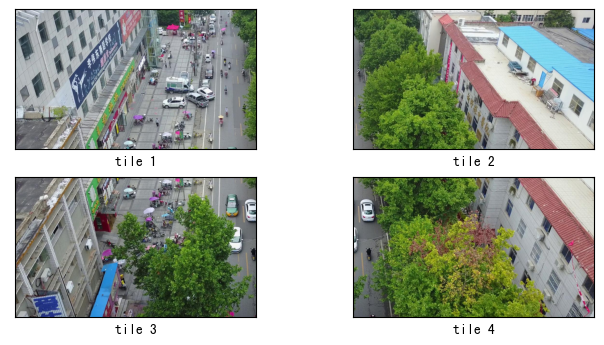

In [10]:
img2 = np.array(Image.open('./data/images/0000001_02999_d_0000005.jpg'))

# split frame to 2 x 2
img2_tiles = frame2tiles(img2, 2, 2, 80)
plt.figure(figsize=(8,4))
for i,tile in enumerate(img2_tiles):
    plt.subplot(2,2,i+1)
    plt.imshow(tile.tile)
    plt.xlabel('tile %d'%(i+1))
    plt.xticks([])
    plt.yticks([])
# plt.savefig('data/images/frame2tiles.svg',format='svg',bbox_inches='tight')

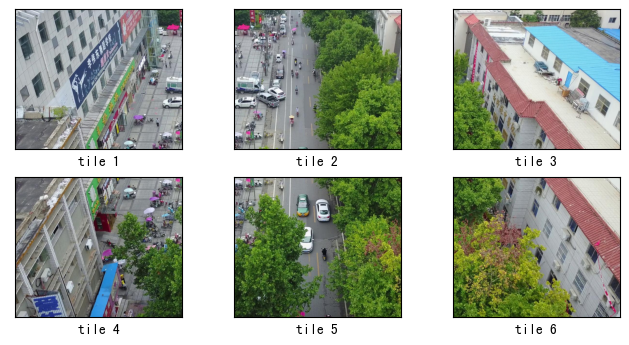

In [9]:
# split frame to 2 x 3
img2_tiles = frame2tiles(img2, 2, 3, 80)
plt.figure(figsize=(8,4))
for i,tile in enumerate(img2_tiles):
    plt.subplot(2,3,i+1)
    plt.imshow(tile.tile)
    plt.xlabel('tile %d'%(i+1))
    plt.xticks([])
    plt.yticks([])

### Object Detection and Prediction Result Processing Correlation Functions

In [4]:
names = ['pedestrian', 'people', 'bicycle', 'car', 'van','truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']
class YOLO: # detect model , call this class return predict bbox
    '''
    return a yolo detector
    '''
    def __init__(self, model='yolov5l-xs-1'):
        weight_path = f'./model/tph-yolov5/weights/{model}.pt'

        model = torch.hub.load('./model/tph-yolov5', 'custom', 
                            path=weight_path, source='local', force_reload=True)
        model.amp = False
        self.model = model

    def __call__(self, img, img_size=640):
        det = self.model(img, img_size)
        return det.pred[0].to('cpu')

class Bbox_Object:
    '''
    bounding box info, transform xyxy format to xywh.
    '''
    def __init__(self, bbox, format='xyxy'):
        if len(bbox.shape) != 2:
            bbox.unsqueeze(dim=0)
        self.bbox = bbox
        self.format = format

    def transfer_format(self, toformat='xyxy'):# Convert the four point form of bbox
        if self.format == toformat:
            return None
        elif toformat == 'xywh':
            w = self.bbox[:, 2] - self.bbox[:, 0]
            h = self.bbox[:, 3] - self.bbox[:, 1]
            self.bbox[:, 2] = w
            self.bbox[:, 3] = h
            self.format = format
        else:
            x2 = self.bbox[:, 0] + self.bbox[:, 2]
            y2 = self.bbox[:, 1] + self.bbox[:, 3]
            self.bbox[:, 2] = x2
            self.bbox[:, 3] = y2
            self.format = format

def NMS(pred, iou_threshold): 
    '''
    Non-Maximum Suppression
    return: index
    '''
    tensor_pred = torch.tensor(pred)
    bboxs = tensor_pred[:, :4]
    scores = tensor_pred[:, 4]
    indices = torchvision.ops.nms(bboxs, scores, iou_threshold) # delete duplicate bbox
    return pred[indices]

def drawBbox(img, pred, hide_labels=True, hide_conf=True):
    from model.YOLOV5.utils.plots import Annotator, colors
    '''
    draw prediction bbox
    return: numpy array image
    '''
    annotator = Annotator(np.ascontiguousarray(img), line_width=2, example=str(names))
    for *xyxy, conf, cls in reversed(pred): # Draw each bbox on the picture
     # Add bbox to image
        c = int(cls)  # integer class
        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
        annotator.box_label(xyxy, label, color=colors(c, True))
    return annotator.result()

def detectTiles(tiles, size, iou_threshold, model):
    '''
    detect tiles one by one, combine predictions and NMS
    return: prediction(torch tensor)
    '''
    for i,tile in enumerate(tiles): # Iterate over each tile
        res = model(tile.tile, size)
        tile.add_pred(res)
        if i == 0:
            pred = tile.pred
        else:
            pred = torch.vstack((pred, tile.pred))
        pred = NMS(pred, iou_threshold) # delete duplicate bbox
    return pred

def detectImage(img, size, iou_threshold, model):
    '''
    detect a image
    return: prediction(torch tensor)
    '''
    pred = model(img, size)
    pred = NMS(pred, iou_threshold)# delete duplicate bbox
    return pred

### Detection effect display

YOLOv5  1def027 torch 1.8.2+cu101 CUDA:0 (GeForce GTX 1050, 4096MiB)

Fusing layers... 
Model Summary: 570 layers, 60425780 parameters, 0 gradients, 145.9 GFLOPs
Adding AutoShape... 


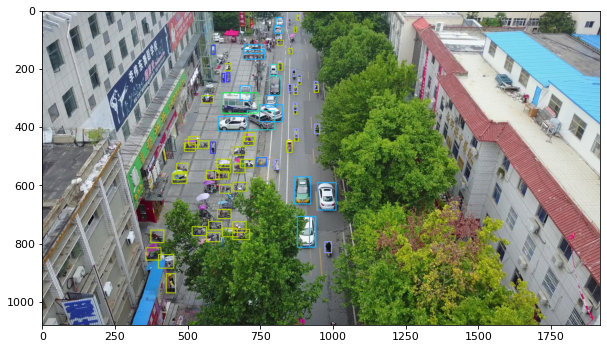

In [5]:
model = YOLO()
pred = detectTiles(img2_tiles, 480, 0.5, model)
res = drawBbox(img2, pred)
plt.figure(figsize=(10, 8))
plt.imshow(res)

### Evaluation function

In [6]:
import datetime

class FPS:
    def __init__(self):
        # store the start time, end time, and total number of frames
        # that were examined between the start and end intervals
        self._start = None
        self._end = None
        self._numFrames = 0

    def start(self):
        # start the timer
        self._start = datetime.datetime.now()
        return self

    def stop(self):
        # stop the timer
        self._end = datetime.datetime.now()

    def update(self):
        # increment the total number of frames examined during the
        # start and end intervals
        self._numFrames += 1

    def elapsed(self):
        # return the total number of seconds between the start and
        # end interval
        return (self._end - self._start).total_seconds()

    def fps(self):
        # compute the (approximate) frames per second
        return self._numFrames / self.elapsed()

    def clear(self):
        self.__init__()

def compute_iou(box1, box2):
    """Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
    Args:
      box1: (tensor) bounding boxes, sized [N,4].
      box2: (tensor) bounding boxes, sized [M,4].
    Return:
      (tensor) iou, sized [N,M].
    """
    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(  
        box1[:, :2].unsqueeze(1).expand(N, M, 2),  # [N,2] -> [N,1,2] -> [N,M,2]
        box2[:, :2].unsqueeze(0).expand(N, M, 2),  # [M,2] -> [1,M,2] -> [N,M,2]
    )

    rb = torch.min(  
        box1[:, 2:].unsqueeze(1).expand(N, M, 2),  # [N,2] -> [N,1,2] -> [N,M,2]
        box2[:, 2:].unsqueeze(0).expand(N, M, 2),  # [M,2] -> [1,M,2] -> [N,M,2]
    )

    wh = rb - lt  
    wh[wh < 0] = 0  
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    area1 = (box1[:, 2]-box1[:, 0]) * (box1[:, 3]-box1[:, 1])  # [N,]
    area2 = (box2[:, 2]-box2[:, 0]) * (box2[:, 3]-box2[:, 1])  # [M,]
    area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
    area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]

    iou = inter / (area1 + area2 - inter)
    return iou

def compute_average_iou(iou_matrix):
    if iou_matrix.shape[1] == 0:
        return 0
    return (iou_matrix.max(0).values.sum() / len(iou_matrix)).item()

### Test algorithm performance

In [7]:
root = './model/tph-yolov5/data/VisDrone/VisDrone2019-DET-val'
labels_txt = [root + '/annotations/' + name for name in os.listdir('./model/tph-yolov5/data/VisDrone/VisDrone2019-DET-val/annotations/')]
img_file = [root + '/images/' + name for name in os.listdir('./model/tph-yolov5/data/VisDrone/VisDrone2019-DET-val/images/')]

img_iou = []
tiles_iou = []
img_time = []
tiles_time = []
fps = FPS()
for i in range(len(labels_txt)):
    iou_threshold = 0.5
    img_label = torch.tensor(np.genfromtxt(labels_txt[i], delimiter=',').reshape((-1, 8)))[:, :4]
    label_bbox = Bbox_Object(img_label, 'xywh')
    label_bbox.transfer_format('xyxy')
    img = np.array(Image.open(img_file[i]))
    
    fps.start()
    tiles = frame2tiles(img, 2, 3, 80)
    tiles_pred = detectTiles(tiles, 480, iou_threshold, model)
    tiles_bbox = Bbox_Object(tiles_pred[:, :4], 'xyxy')
    tiles_iou_matrix = compute_iou(label_bbox.bbox, tiles_bbox.bbox)
    tiles_avg_iou = compute_average_iou(tiles_iou_matrix)
    tiles_iou.append(tiles_avg_iou)
    fps.stop()
    tiles_time.append(fps.elapsed())
    
    fps.start()
    img_pred = detectImage(img, 960, iou_threshold, model)
    img_bbox = Bbox_Object(img_pred[:, :4], 'xyxy')
    img_iou_matrix = compute_iou(label_bbox.bbox, img_bbox.bbox)
    img_avg_iou = compute_average_iou(img_iou_matrix)
    img_iou.append(img_avg_iou)
    fps.stop()
    img_time.append(fps.elapsed())

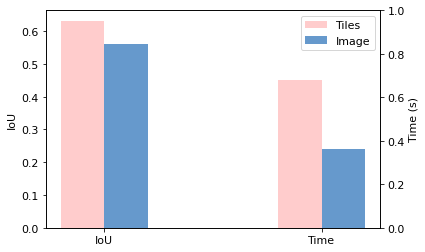

In [8]:
x = np.arange(2)
tiles = [np.mean(tiles_iou), np.mean(img_iou)]
img = [np.mean(tiles_time), np.mean(img_time)]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.bar(x, tiles, width=0.2, label = 'Tiles',color = '#FFCCCC');
ax1.bar(x + 0.2, img, width=0.2, label = 'Image',color = '#6699CC')
ax1.set_ylabel('IoU');
ax2 = ax1.twinx() # this is the important function
plt.xticks(x+0.1, ['IoU', 'Time'])
ax2.set_ylabel('Time (s)');
ax1.legend()
plt.show()
# fig.savefig('./data/images/acc.svg', format='svg')